NetworkX simple tutorial

In [ ]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

In [ ]:
pip install networkx matplotlib trimesh pandas skorch

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

In [37]:
!conda --version

conda 23.1.0


Graph edges as:
- matrix = dense => O(|V^2|)
- indices = sparse => O(|E|) <= O(|V^2|)

We store a feature matrix X ∈ R(n×h), then
- Edges: a matrix of indices E ∈ N2×m
- Triangles: a matrix of indices T ∈ N3×t
- Attributes: feature matrices WE ∈ Rm×he and/or WT ∈ R(t×h).T

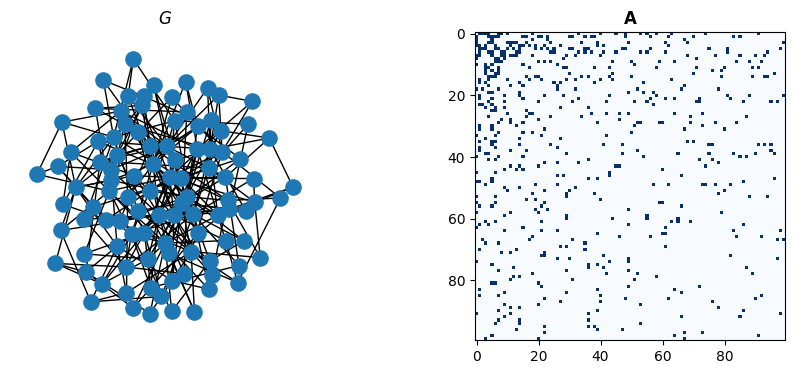

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.barabasi_albert_graph(100, 3)
_, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.5})
nx.draw_kamada_kawai(G, ax=axes[0], node_size=120)
axes[1].imshow(nx.to_numpy_array(G), aspect='auto', cmap='Blues')
axes[0].set_title("$G$")
axes[1].set_title("$\mathbf{A}$")
plt.show()

In [6]:
import torch
from torch_geometric.data import Data
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

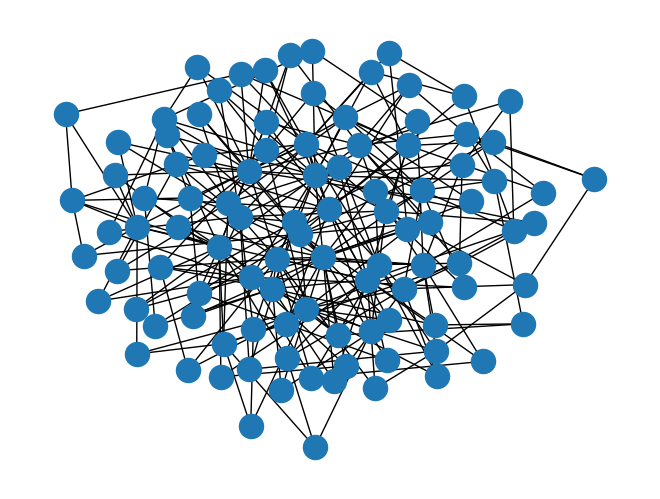

In [5]:
import networkx as nx
G = nx.barabasi_albert_graph(n=100, m=3)
nx.draw_kamada_kawai(G)

In [7]:
pip install rdkit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 8.1 MB/s eta 0:00:00


In [13]:
from torch_geometric.data import InMemoryDataset, download_url
from rdkit import Chem
import pandas as pd
from google.colab import userdata

class COVID(InMemoryDataset):
  urlname = userdata.get('URL_TUT')
  url = urlname

  def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
    super(COVID, self).__init__(root, transform, pre_transform, pre_filter)

    self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_file_names(self):
    return ['mpro_xchem.csv']

  @property
  def processed_file_names(self):
    return ['data.pt']

  def download(self):
    download_url(self.url, self.raw_dir)

  def process(self):
    df = pd.read_csv(self.raw_paths[0])
    data_list = []

    for smiles, label in df.itertuples(False, None):
      mol = Chem.MolFromSmiles(smiles)
      adj = Chem.GetAdjacencyMatrix(mol)

      data = Data(num_nodes=adj.shape[0], edge_index=torch.Tensor(adj).nonzero().T, y=label)
      data_list.append(data)

    self.data, self.slices = self.collate(data_list)
    torch.save((self.data, self.slices), self.processed_paths[0])

In [15]:
covid = COVID(root='./data/COVID/')
covid

COVID(880)

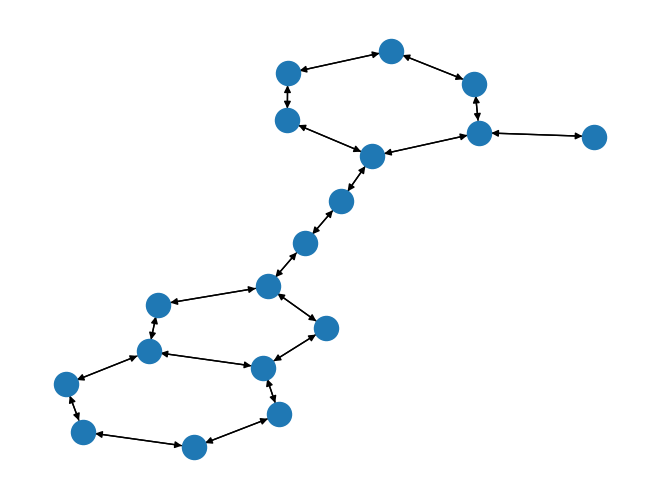

In [16]:
G = torch_geometric.utils.to_networkx(covid[0])
nx.draw_kamada_kawai(G)

## MessagePassing
- Sequentially done connected components using Disjoint Sets

In [22]:
import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.datasets import TUDataset

class ConnectedComponents(MessagePassing):
  def __init__(self):
    super(ConnectedComponents, self).__init__(aggr="max")

  def forward(self, data):
    x = torch.arange(data.num_nodes).view(-1, 1)

    last_x = torch.zeros_like(x)
    while not x.equal(last_x):
      last_x = x.clone()
      x = self.propagate(data.edge_index, x=x)
      x = torch.max(x, last_x)

    unique, perm = torch.unique(x, return_inverse=True)
    perm = perm.view(-1)

    if "batch" not in data:
      return unique.size(0), perm

    cc_batch = unique.scatter(dim=-1, index=perm, src=data.batch)

    return cc_batch.bincount(minlength=data.num_graphs), perm

  def message(self, x_j):
    return x_j

  def update(self, aggr_out):
    return aggr_out

In [24]:
ds = TUDataset(root='./data/', name='PROTEINS')
data = torch_geometric.data.Batch.from_data_list(ds[:10])
cc = ConnectedComponents()
count, perm = cc(data)
count

tensor([1, 1, 1, 1, 1, 8, 4, 1, 1, 1])

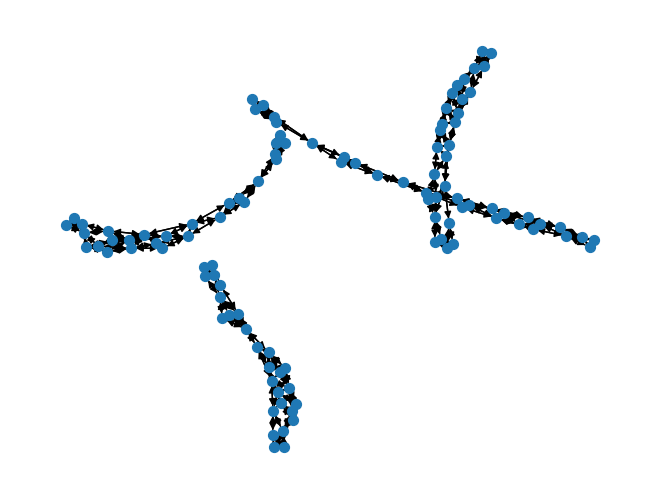

In [26]:
G = torch_geometric.utils.to_networkx(ds[6])
nx.draw(G, node_size=50)

In [34]:
from torch_geometric.nn import GCNConv, JumpingKnowledge, global_add_pool
from torch.nn import functional as F
from torch_geometric.data import Batch

class SimpleGNN(torch.nn.Module):
  def __init__(self, dataset, hidden=64, layers=6):
    super(SimpleGNN, self).__init__()
    self.dataset = dataset
    self.convs = torch.nn.ModuleList()

    self.convs.append(GCNConv(in_channels=dataset.num_node_features, out_channels=hidden))

    for _ in range(1, layers):
      self.convs.append(GCNConv(in_channels=hidden, out_channels=hidden))

    self.jk = JumpingKnowledge(mode="cat")
    self.jk_lin = torch.nn.Linear(in_features=hidden*layers, out_features=hidden)
    self.lin_1 = torch.nn.Linear(in_features=hidden, out_features=hidden)
    self.lin_2 = torch.nn.Linear(in_features=hidden, out_features=dataset.num_classes)

  def forward(self, index):
    data = Batch.from_data_list(self.dataset[index])
    x = data.x
    xs = []

    for conv in self.convs:
      x = F.relu(conv(x=x, edge_index=data.edge_index))
      xs.append(x)

    x = self.jk(xs)
    x = F.relu(self.jk_lin(x))
    x = global_add_pool(x, batch=data.batch)
    x = F.relu(self.lin_1(x))
    x = F.softmax(self.lin_2(x), dim=-1)

    return x

In [35]:
ohd = torch_geometric.transforms.OneHotDegree(max_degree=4)
covid = COVID(root='./data/COVID/', transform=ohd)
covid[0]

Data(edge_index=[2, 40], y=[1], num_nodes=18, x=[18, 5])

In [36]:
from skorch import NeuralNetClassifier
X, y = torch.arange(len(covid)).long(), covid.data.y
net = NeuralNetClassifier(
  module=SimpleGNN,
  module__dataset=covid,
  max_epochs=20,
  batch_size=-1,
  lr=0.001
)
fit = net.fit(X, y)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6579       0.9091        0.6597  0.5984
      2        0.6537       0.9091        0.6566  0.2979
      3        0.6497       0.9091        0.6535  0.2860
      4        0.6458       0.9091        0.6505  0.2876
      5        0.6421       0.9091        0.6476  0.2856
      6        0.6384       0.9091        0.6447  0.2921
      7        0.6349       0.9091        0.6420  0.2797
      8        0.6315       0.9091        0.6393  0.2769
      9        0.6282       0.9091        0.6366  0.2763
     10        0.6249       0.9091        0.6341  0.2897
     11        0.6217       0.9091        0.6316  0.2764
     12        0.6185       0.9091        0.6291  0.2827
     13        0.6154       0.9091        0.6267  0.2899
     14        0.6123       0.9091        0.6243  0.2867
     15        0.6093       0.9091        0.6219  0.2811
     16        0.6063       0.9